## CNN inference example in Pytorch

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import pycomlink as pycml
from pycomlink.processing.pytorch_util import run_inference

c:\Users\lukas\Documents\OpenSense\pycomlink\pycomlink\io\examples.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
# Enhanced debugging to understand the platform difference
import zipfile
import os
import torch
import platform

print(f"Platform: {platform.system()}")
print(f"PyTorch version: {torch.__version__}")

cache_dir = os.path.expanduser("~/.cml_wd_pytorch/models/")
if os.path.exists(cache_dir):
    files = [f for f in os.listdir(cache_dir) if f.endswith('.pt2')]
    if files:
        model_file = os.path.join(cache_dir, files[0])
        print(f"\nModel file: {model_file}")
        
        # Test what torch.export.load is actually looking for
        try:
            print("\n=== Testing torch.export.load behavior ===")
            exported_program = torch.export.load(model_file)
            print("SUCCESS: torch.export.load worked!")
        except Exception as e:
            print(f"FAILED: {e}")
            
            # Check what files torch.export.load expects vs what exists
            with zipfile.ZipFile(model_file, 'r') as zipf:
                file_list = zipf.namelist()
                print(f"\nFiles in archive: {file_list}")
                
                # Check if there are different expectations
                expected_files = ['version', 'data.pkl', 'constants.pkl']
                print(f"\nChecking for commonly expected files:")
                for expected in expected_files:
                    if expected in file_list:
                        print(f"  ✓ {expected} found")
                    else:
                        print(f"  ✗ {expected} missing")
                        # Look for similar files
                        similar = [f for f in file_list if expected in f]
                        if similar:
                            print(f"    Similar files: {similar}")
        
        # Also test the specific error path
        print(f"\n=== Testing specific file access ===")
        with zipfile.ZipFile(model_file, 'r') as zipf:
            try:
                version_data = zipf.read('version')
                print("✓ Can read 'version' at root")
            except KeyError:
                print("✗ Cannot read 'version' at root")
                try:
                    version_data = zipf.read('best_model_exported/.data/version')
                    print("✓ Can read 'best_model_exported/.data/version'")
                    print(f"  Content: {version_data.decode().strip()}")
                except KeyError:
                    print("✗ Cannot read version file at nested path either")

In [2]:
# Load data
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

In [3]:
# Dataarray shape is expected to be (time, channels, cml_id)
tl = cmls.tl.transpose('time', 'channel_id', 'cml_id')

# Normalisation
tl_normed = tl - tl.median(dim='time')

# Standardization should be part of the specific model, because it is trained with specific preprocessing

### Option 1: Load DL model and set up a path for model weights

Only working on Linux

In [ ]:
# Loading from file should support .pt2 and optional config.yml 
# also with hardcoded reflength: 60 if the config isn't available

# Set up your own path:
weights_path = 'C:/Users/lukas/.cml_wd_pytorch/models/best_model_exported.pt2'
result = run_inference.cnn_wd(model_path_or_url=weights_path, data=tl_normed)

### Option 2: Load the model from URL and cahe it

Only working on Linux

In [ ]:
# TODO: We need one simple class for example polz_2025_cnn, which loads specific cnn.py model and weights in .pt2 file from url
# so none of those will be in pycomlink
# the user should only choose a model by a name and the rest of the complexity is hidden
# leave the url option
# config should be optional, if its not provided, set reflength: 60  # Length of the radar data to consider for rainfall rate or wet label calculation

## something like this:
#model_url = "https://github ... .pt2"
#config_url_or_path = ...       # if none, reflength will be set to 60
#result = pytorch_util.cnn_wd(model_url, config_url_or_path, data=tl_normed)

# TODO: works only with batch-size = 1
model_URL = "https://github.com/jpolz/cml_wd_pytorch/raw/refs/heads/jpolz/main/flexible_metrics/data/dummy_model/best_model_exported.pt2"
result = run_inference.cnn_wd(model_path_or_url=model_URL,data=tl_normed, batch_size=1)

### Option 3: Load the model using cnn.py class and weights from local path
Working on Linux and Windows

In [4]:
model_path = "C:/Users/lukas/Documents/OpenSense/temp_for_cnn_models/model_epoch_15.pth"
result = run_inference.cnn_wd(model_path_or_url=model_path,data=tl_normed)

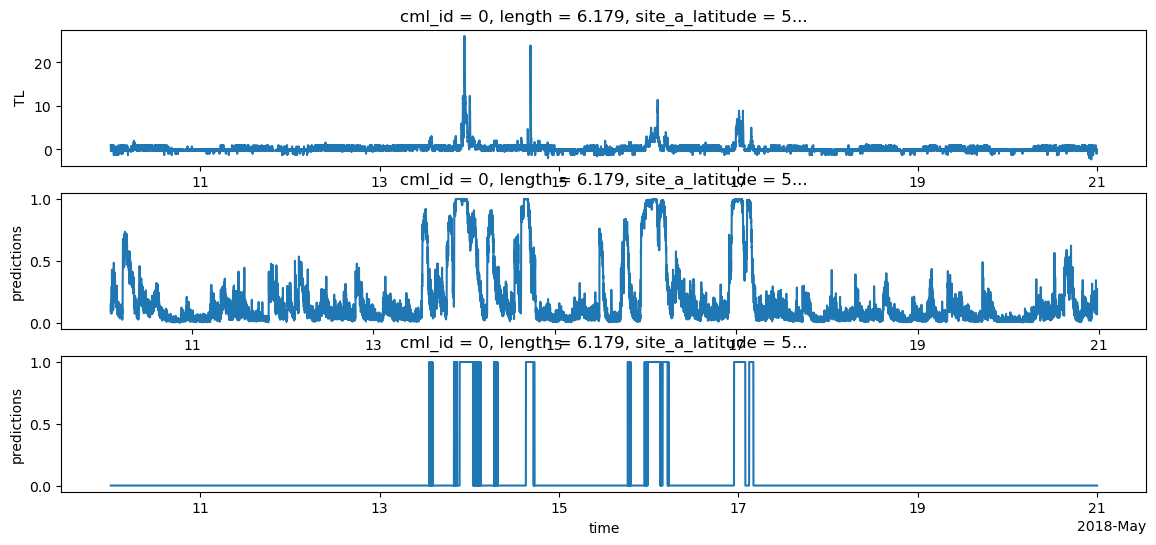

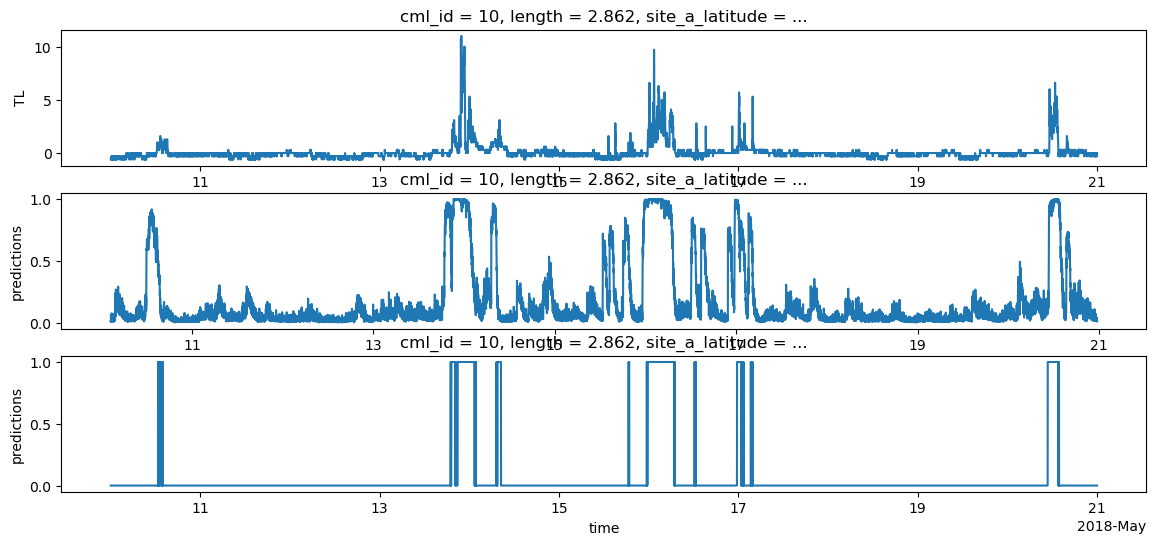

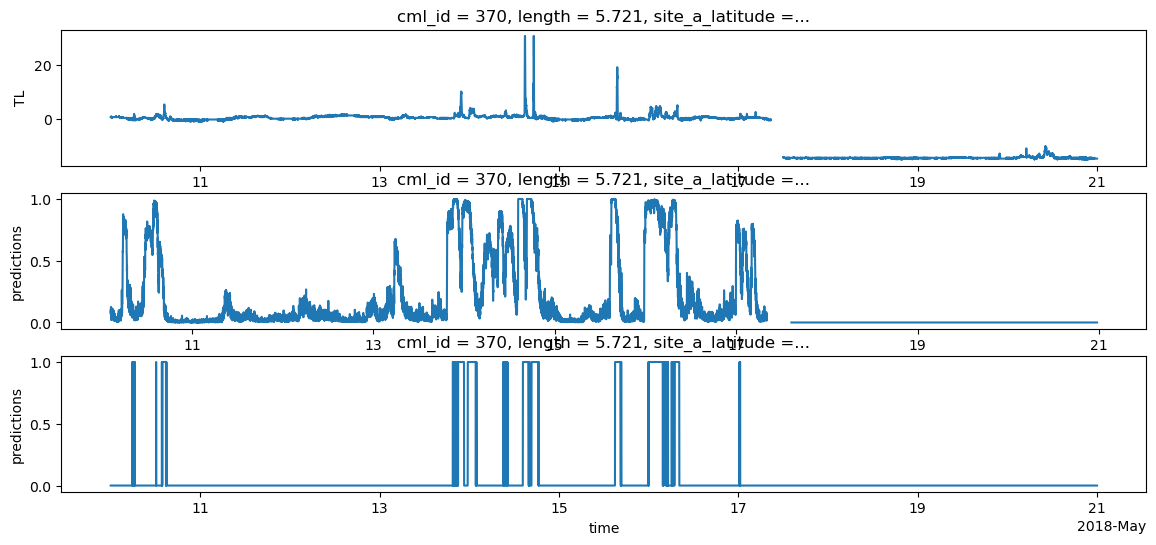

In [5]:
for cml_id in cmls.cml_id.data:
    fig, axs = plt.subplots(3, 1, figsize=(14, 6))
    result.TL.sel(cml_id=cml_id).isel(channel_id=0).plot.line(x='time', ax=axs[0])
    result.predictions.sel(cml_id=cml_id).plot.line(x='time', ax=axs[1])
    (result.predictions.sel(cml_id=cml_id)>0.8).plot.line(x='time', ax=axs[2])
    
